# Content and Objectives

- Show effects of inter-symbol-interference 
- Illustrated as distortion in the continuous time signal, sampled symbols, and in the BER
- BPSK symbols are being pulse-shaped, transmitted on a given multi-path channel (you may play around with this), and processed in the receiver

# Import

In [27]:
# importing
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

# interactive content
from ipywidgets import interactive
import ipywidgets as widgets

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 24}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

matplotlib.rc('figure', figsize=(14, 6) )

# Function for determining the impulse response of an RRC filter

In [3]:
########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_up, t_symb, r):
        
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    At poles, values of wikipedia.de were used (without cross-checking)
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter ceofficients
    '''

    assert K % 2 != 0, "Filter length needs to be odd"
    
    if r == 0:
        r = 1e-32

    # init
    rrc = np.zeros(K)
    t_sample = t_symb/n_up
    
        
    i_steps = np.arange( 0, K)
    k_steps = np.arange( -(K-1)/2.0, (K-1)/2.0 + 1 )    
    t_steps = k_steps*t_sample

    for i in i_steps:

        if t_steps[i] == 0:
            rrc[i] = 1.0/np.sqrt(t_symb) * (1.0 - r + 4.0 * r / np.pi )

        elif np.abs( t_steps[i] ) == t_symb/4.0/r:
            rrc[i] = r/np.sqrt(2.0*t_symb)*((1+2/np.pi)*np.sin(np.pi/4.0/r)+ \
                            ( 1.0 - 2.0/np.pi ) * np.cos(np.pi/4.0/r) )

        else:
            rrc[i] = 1.0/np.sqrt(t_symb)*( np.sin( np.pi*t_steps[i]/t_symb*(1-r) ) + \
                            4.0*r*t_steps[i]/t_symb * np.cos( np.pi*t_steps[i]/t_symb*(1+r) ) ) \
                            / (np.pi*t_steps[i]/t_symb*(1.0-(4.0*r*t_steps[i]/t_symb)**2.0))
 
    return rrc

# Parameters

In [4]:
# number of symbols per sequence/packet
n_symb = 32

# modulation scheme and constellation points
M = 2
constellation = [ -1, 1 ]

# EbN0 range for simulation
EbN0_dB = np.arange( 0, 30, 2)
EbN0 = 10**(EbN0_dB/10)


# maximum number of errors and symbols to be simulated
max_errors = 1000
max_syms = 1e7

# parameters of the filter
r = 0.33

n_up = 8            # samples per symbol
syms_per_filt = 4   # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_up + 1         # length of the fir filter

# set symbol time 
t_symb = 1.0 

# Define channel characteristics and get channel impulse response

In [5]:
# define channel by characterizing delays and according attenuation
channel_delays_syms = range( 7 )
channel_factors = [ 1, .4, -.3, .1, .1, .05, .05 ]

assert( len(channel_delays_syms) == len(channel_factors) ), 'Length of delays and factors has to be the same!'

# get channel 
h_channel = np.zeros( (np.max(channel_delays_syms)+1) * n_up )

for k in np.arange(len(channel_delays_syms)):
    h_channel[ n_up*channel_delays_syms[k] ] = channel_factors[k]


# Simulation loop

In [6]:
# find rrc response and normalize to energy 1
rrc = get_rrc_ir( K_filt, n_up, t_symb, r)
rrc = rrc / np.linalg.norm(rrc)

# initialize BER  
ber = np.zeros_like( EbN0, dtype=float ) 

# theoretical values
ber_bpsk = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0 ) )


# loop for snrs
for ind_ebn0, val_ebn0 in enumerate( EbN0 ):

    # get noise variance for simulation
    sigma2 = 1 / (np.log2(M) * val_ebn0)
    
    # initialize counter
    num_errors = 0
    num_syms = 0

    # loop for errors
    while (num_errors<max_errors and num_syms<max_syms):    
    
        # generate random binary vector and modulate 
        data = np.random.randint( 2, size=n_symb)
        s = [ constellation[d] for d in data ]
          
        # prepare sequence to be filtered by upsampling 
        s_up = np.zeros( n_symb * n_up, dtype=complex)        
        s_up[ : : n_up ] = s
    
        # apply RRC filtering for Tx pulse shaping     
        s_Tx = np.convolve( s_up, rrc)    
    
        # apply channel and add noise
        s_Rx = np.convolve( s_Tx, h_channel)

        n = np.sqrt(sigma2/2) * ( np.random.randn(len(s_Rx)) + 1j* np.random.randn(len(s_Rx)) )
    
        r_Rx = s_Rx + n
    
        # apply MF at the Rx 
        y_mf_rrc = np.convolve(r_Rx, rrc)
        
        # down-sampling from "high rate" (n_up samples per symbol) to symbol rate
        y_down = y_mf_rrc[ K_filt-1 : K_filt-1 + n_symb*n_up : n_up ]
        
        # demodulate
        data_est = [ int( np.real( rec ) > 0 ) for rec in y_down ]

        # count errors and symbols
        num_errors += sum( [ int( data_est[ _n ] != data[ _n ] ) for _n in range(len(data)) ] )
        num_syms += n_symb

        # get estimate of BER
        ber[ ind_ebn0 ] = num_errors/(num_syms*1.0*np.log2(M))
        
    print('EbN0 simulated:', 10*np.log10( val_ebn0) )
    
print('\n\nError floor at: \t\t\t{:0.4f}'.format(ber[-1]))
print('For comparison: 2^length of h = \t{:0.4f}'.format(2**(-len(channel_delays_syms))) )

EbN0 simulated: 0.0
EbN0 simulated: 2.0000000000000004
EbN0 simulated: 4.0
EbN0 simulated: 6.0
EbN0 simulated: 8.0
EbN0 simulated: 10.0
EbN0 simulated: 12.0
EbN0 simulated: 14.0
EbN0 simulated: 16.0
EbN0 simulated: 18.0
EbN0 simulated: 20.0
EbN0 simulated: 22.0
EbN0 simulated: 24.0
EbN0 simulated: 26.0
EbN0 simulated: 28.0


Error floor at: 			0.0071
For comparison: 2^length of h = 	0.0078


# Plotting

C:\Users\schmalen\AppData\Local\Temp\ipykernel_14744\4230485168.py:30: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  markerline, stemlines, baseline = plt.stem( np.arange(len(y_down)), np.real(y_down), '+', label='$z[k]$ (Rx)')


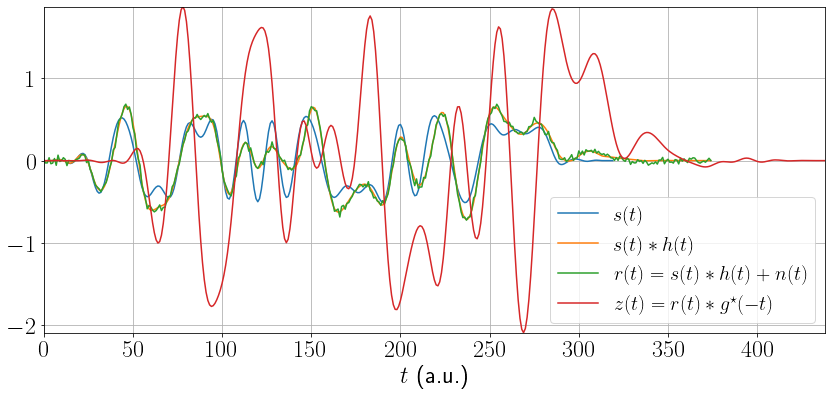

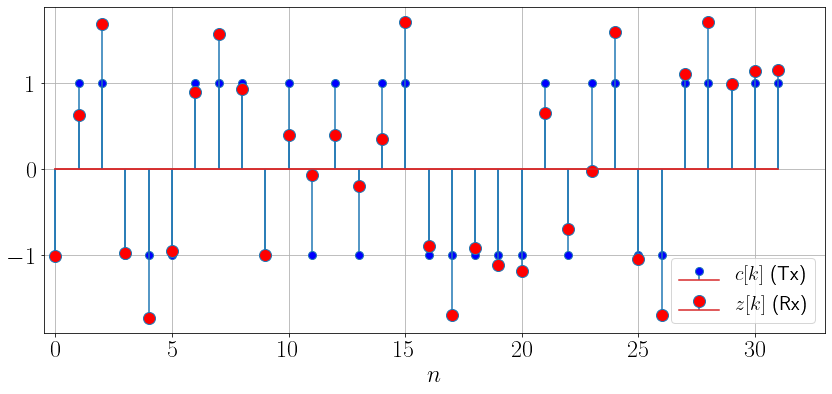

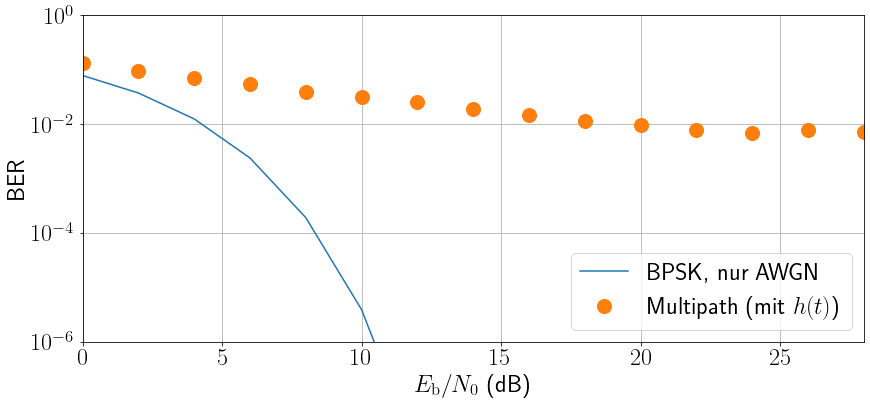

In [24]:
# activate switches to plot whatever you like to see
show_signal = 1
show_ber = 1
show_symbols = 1


# plot signals
if show_signal:
    
    plt.figure()

    plt.plot( np.real(s_Tx), label='$s(t)$')
    plt.plot( np.real(s_Rx), label='$s(t)* h(t)$')
    plt.plot( np.real(r_Rx), label='$r(t)= s(t)*h(t)+n(t)$')
    plt.plot( np.real(y_mf_rrc), label='$z(t)=r(t)*g^\star(-t)$')
    
    plt.grid(True)
    plt.xlabel('$t$ (a.u.)')
    plt.autoscale(enable=True, tight=True)
    plt.legend(loc='lower right', fontsize=20)
    plt.savefig('waveform_isi.pdf',bbox_inches='tight')
    
# show data symbols after processing
if show_symbols:
    plt.figure()

    markerline, stemlines, baseline = plt.stem( np.arange(len(s)), np.real(s), label='$c[k]$ (Tx)')
    plt.setp(markerline, 'markersize', 8, 'markerfacecolor', 'b')

    markerline, stemlines, baseline = plt.stem( np.arange(len(y_down)), np.real(y_down), '+', label='$z[k]$ (Rx)')
    plt.setp(markerline, 'markersize', 12,  'markerfacecolor', 'r',)

    plt.legend(loc='lower right', fontsize=20)
    plt.xlim([-0.5, 33])
    plt.grid(True)
    plt.xlabel('$n$')
    plt.savefig('decision_isi.pdf',bbox_inches='tight')

# show BER
if show_ber:
    plt.figure()
    
    plt.plot(EbN0_dB, ber_bpsk,  label="BPSK, nur AWGN")
    plt.plot(EbN0_dB, ber, 'o', ms=14, label="Multipath (mit $h(t)$)")

    plt.yscale('log')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.xlabel('$E_{\mathrm{b}}/N_0$ (dB)')
    plt.ylabel('BER')
    plt.autoscale(enable=True, tight=True)
    plt.ylim( (1e-6,1))
    plt.savefig('ber_isi.pdf',bbox_inches='tight')

# Interactive Demo

In [40]:
# generate random binary vector and modulate 
data = np.random.randint( 2, size=n_symb)
s = [ constellation[d] for d in data ]

# prepare sequence to be filtered by upsampling 
s_up = np.zeros( n_symb * n_up, dtype=complex)        
s_up[ : : n_up ] = s

# apply RRC filtering for Tx pulse shaping     
s_Tx = np.convolve( s_up, rrc)    
    
def plot_waveform_and_symbols(plot_aftermf, h_1, h_2, h_3, h_4, h_5, h_6, h_7, EbN0):
    # define channel by characterizing delays and according attenuation
    channel_delays_syms = range( 7 )
    channel_factors = [ h_1, h_2, h_3, h_4, h_5, h_6, h_7 ]

    assert( len(channel_delays_syms) == len(channel_factors) ), 'Length of delays and factors has to be the same!'

    # get channel 
    h_channel = np.zeros( (np.max(channel_delays_syms)+1) * n_up )

    for k in np.arange(len(channel_delays_syms)):
        h_channel[ n_up*channel_delays_syms[k] ] = channel_factors[k]
        
    # find rrc response and normalize to energy 1
    rrc = get_rrc_ir( K_filt, n_up, t_symb, r)
    rrc = rrc / np.linalg.norm(rrc)
    
    sigma2 = 1 / (np.log2(M) * 10**(EbN0/10))
    
    

    # apply channel and add noise
    s_Rx = np.convolve( s_Tx, h_channel)

    n = np.sqrt(sigma2/2) * ( np.random.randn(len(s_Rx)) + 1j* np.random.randn(len(s_Rx)) )

    r_Rx = s_Rx + n

    # apply MF at the Rx 
    y_mf_rrc = np.convolve(r_Rx, rrc)

    # down-sampling from "high rate" (n_up samples per symbol) to symbol rate
    y_down = y_mf_rrc[ K_filt-1 : K_filt-1 + n_symb*n_up : n_up ]

    # demodulate
    data_est = [ int( np.real( rec ) > 0 ) for rec in y_down ]

    plt.figure(1,figsize=(15,6))

    plt.plot( np.real(s_Tx), label='$s(t)$')
    plt.plot( np.real(s_Rx), label='$s(t)* h(t)$')
    plt.plot( np.real(r_Rx), label='$r(t)= s(t)*h(t)+n(t)$')
    if plot_aftermf:
        plt.plot( np.real(y_mf_rrc[(K_filt-1)//2:]), label='$z(t)=r(t)*g^\star(-t)$')
        
    plt.grid(True)
    plt.xlabel('$t$ (a.u.)')
    plt.autoscale(enable=True, tight=True)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()
    
    # show data symbols after processing
    plt.figure(2,figsize=(15,6))

    markerline, stemlines, baseline = plt.stem( np.arange(len(s)), np.real(s) ) #, label=r'$c[k]$')
    plt.setp(markerline, 'markersize', 8, 'markerfacecolor', 'b')

    markerline, stemlines, baseline = plt.stem( np.arange(len(y_down)), np.real(y_down) )#, '+', label=r'$z[k]$')
    plt.setp(markerline, 'markersize', 12,  'markerfacecolor', 'r',)

    plt.legend(['$c[k]$', '$z[k]$'], loc='upper right',fontsize=20)
    plt.grid(True)
    plt.xlabel('$n$')
    plt.show()

In [41]:
style = {'description_width': 'initial'}
interactive_update = interactive(plot_waveform_and_symbols, \
                                 plot_aftermf = widgets.Checkbox(value=False, continuous_update=False, description=r'Plot $z(t)$?'), \
                                 h_1 = widgets.FloatSlider(min=0,max=1,step=0.01,value=1, continuous_update=False, description=r'$h[0]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_2 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[1]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_3 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[2]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_4 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[3]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_5 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[4]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_6 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[5]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 h_7 = widgets.FloatSlider(min=-0.5,max=1,step=0.01,value=0, continuous_update=False, description=r'$h[6]$', layout=widgets.Layout(width='75%'), style=style),  \
                                 EbN0 = widgets.FloatSlider(min=10,max=25,step=1,value=25, continuous_update=False, description=r'$E_{\mathrm{b}}$ / $N_0$ (dB)', layout=widgets.Layout(width='75%'), style=style))

output = interactive_update.children[-1]
output.layout.height = '900px'
interactive_update

interactive(children=(Checkbox(value=False, description='Plot $z(t)$?'), FloatSlider(value=1.0, continuous_upd…